In [511]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
from scipy.special import boxcox1p
from scipy.stats import boxcox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [482]:
data = pd.read_csv('data/importaciones_gasolina.csv')

# Seleccionando columnas de interes
columns = ['Fecha', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Gas licuado de petróleo', 'Gasolina regular', 'Gasolina superior', 'Diesel alto azufre']
data = data[columns]

# Renombrando columnas
new_column_names = ['fecha', 'diesel_bajo_azufre', 'diesel_ultra_bajo_azufre', 'gas_licuado_petroleo', 'gasolina_regular', 'gasolina_superior', 'diesel_alto_azufre']
data.columns = new_column_names

# Eliminando filas con valores nulos
data = data.dropna()

# Convirtiendo fecha a formato datetime
data['fecha'] = pd.to_datetime(data['fecha'])

data


/var/folders/wd/kpmqk46j1wq467f_h9w8l5440000gn/T/ipykernel_12212/1056520668.py:15: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,fecha,diesel_bajo_azufre,diesel_ultra_bajo_azufre,gas_licuado_petroleo,gasolina_regular,gasolina_superior,diesel_alto_azufre
0,2001-01-01,0.00,0.00,"194,065.74","177,776.50","373,963.96","566,101.99"
1,2001-02-01,0.00,0.00,"170,703.38","123,115.99","243,091.07","489,525.80"
2,2001-03-01,0.00,0.00,"161,837.37","161,726.42","312,084.38","575,559.68"
3,2001-04-01,0.00,0.00,"163,048.64","127,338.74","285,054.89","437,745.42"
4,2001-05-01,0.00,0.00,"171,518.86","168,730.19","300,913.67","552,609.13"
...,...,...,...,...,...,...,...
264,2023-01-01,"1,442,099.08","45,074.97","497,780.69","909,391.13","578,792.14",0.00
265,2023-02-01,"1,267,967.39",0.00,"652,984.71","725,101.20","685,183.06",0.00
266,2023-03-01,"1,317,519.91","4,985.21","711,978.35","803,262.67","633,849.05",0.00
267,2023-04-01,"1,417,182.73","21,503.98","647,666.30","922,032.39","572,201.36",0.00


In [483]:
data['mes'] = data['fecha'].dt.month
columns = [col for col in data.columns if col not in ['fecha', 'mes', 'anio']]

frequency_rows = len(columns) // 3 + 1
frequency_cols = 2

height_p_i_m = 400 
height_p_i_m = height_p_i_m * frequency_rows*0.7

fig = make_subplots(rows=frequency_rows, cols=frequency_cols, subplot_titles=[f"IMPORTACIONES {' '.join(column.split('_')).upper()}" for column in columns])

for idx, column in enumerate(columns, 1):
    try:
        data[column] = pd.to_numeric(data[column].str.replace(',', ''))
    except AttributeError:
        pass

    monthly_values = data.groupby('mes')[column].sum()
    trace = go.Bar(x=monthly_values.index, y=monthly_values.values, name=f"Total de {' '.join(column.split('_'))} por mes")
    fig.add_trace(trace, row=(idx-1)//frequency_cols + 1, col=(idx-1)%frequency_cols + 1)

fig.update_layout(showlegend=False, title_text="Importaciones en meses", height=height_p_i_m)
fig.show()

In [484]:
data['anio'] = data['fecha'].dt.year
data['mes'] = data['fecha'].dt.month

frequency_cols = 2
columns = [col for col in data.columns if col not in ['fecha', 'mes', 'anio']]
fig = make_subplots(rows=frequency_rows, cols=frequency_cols, subplot_titles=[f"Comportamiento de {' '.join(column.split('_'))} (2001-2023)" for column in columns], vertical_spacing=0.12)

for i, column in enumerate(columns):
    try:
        data[column] = pd.to_numeric(data[column].str.replace(',', ''))
    except AttributeError:
        pass

    year_values = data.groupby('anio')[column].sum()
    trace = go.Scatter(x=year_values.index, y=year_values.values, name=f"Total {' '.join(column.split('_'))}", mode='lines+markers')    
    fig.add_trace(trace, row=(i // frequency_cols) + 1, col=(i % frequency_cols) + 1)

height_p = 350 
height_p = height_p * frequency_rows

fig.update_layout(showlegend=False, height=height_p)
fig.update_xaxes(title_text="Año")
fig.update_yaxes(title_text=f"Total")

fig.show()


## Serie - Importación mensual de gasolina diesel

- Inicio: 2001-01-01
- Fin: 2023-05-01
- Frecuencia: Mensual

In [485]:
data_dba = data[data['fecha'] >= '2018-01-01']
data_daa = data[data['fecha'] <= '2017-12-01']

data_dba = data_dba.rename(columns={'diesel_bajo_azufre': 'diesel'})
data_daa = data_daa.rename(columns={'diesel_alto_azufre': 'diesel'})

data_diesel = pd.concat([data_dba, data_daa], axis=0)
data_diesel = data_diesel.sort_values(by='fecha')

data_diesel = data_diesel.drop(columns=['diesel_alto_azufre', 'diesel_bajo_azufre', 'diesel_ultra_bajo_azufre'])

In [486]:
data_diesel.freq = 'M'

data_diesel = data_diesel.copy() 
data_diesel['media_movil'] = data_diesel['diesel'].rolling(window=12).mean()
rolling_mean = data_diesel['diesel'].rolling(window=12).mean()

fig = px.line(data_diesel, x='fecha', y='diesel', labels={'diesel': 'Cantidad de diesel Bajo Azufre'}, title='Diesel Bajo Azufre por mes cada año', markers=True)
fig.add_scatter(x=data_diesel['fecha'], y=rolling_mean, mode='lines', name='Media móvil - 12 meses')

fig.update_xaxes(tickformat="%Y", title_text='Año')
fig.update_traces(line=dict(width=2.5))
fig.show()


A primera vista no se observa estacionaridad en media ni en varianza.

### Descomposición de la serie

In [487]:
d_serie_dba = seasonal_decompose(data_diesel.set_index('fecha')['diesel'].astype(float))
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Tendencia', 'Estacionalidad', 'Aleatoriedad'))

fig.add_trace(go.Scatter(x=d_serie_dba.trend.index, y=d_serie_dba.trend, mode='lines', name='Tendencia'), row=1, col=1)
fig.add_trace(go.Scatter(x=d_serie_dba.seasonal.index, y=d_serie_dba.seasonal, mode='lines', name='Estacionalidad'), row=2, col=1)
fig.add_trace(go.Scatter(x=d_serie_dba.resid.index, y=d_serie_dba.resid, mode='lines', name='Aleatoriedad'), row=3, col=1)

fig.update_layout(title='Descomposición de la serie de tiempo - Diesel Bajo Azufre')
fig.show()

Hay una tendencia evidente y una estacionalidad notable. En cuanto al componente de aleatoriedad, no se identifica ningún patrón.

### Transformación de la serie
La serie requiere una transformación de tipo box-cox dado que no es estacionaria en varianza.

In [488]:
data_diesel['diesel_boxcox'] = boxcox1p(data_diesel['diesel'], 0.49)
fig = px.line(data_diesel, x='fecha', y='diesel_boxcox', title='Diesel - Transformación box cox', markers=True)

fig.show()


Se ve un ligero cambio al momento de aplicar box-cox.

### Estacionaridad en media

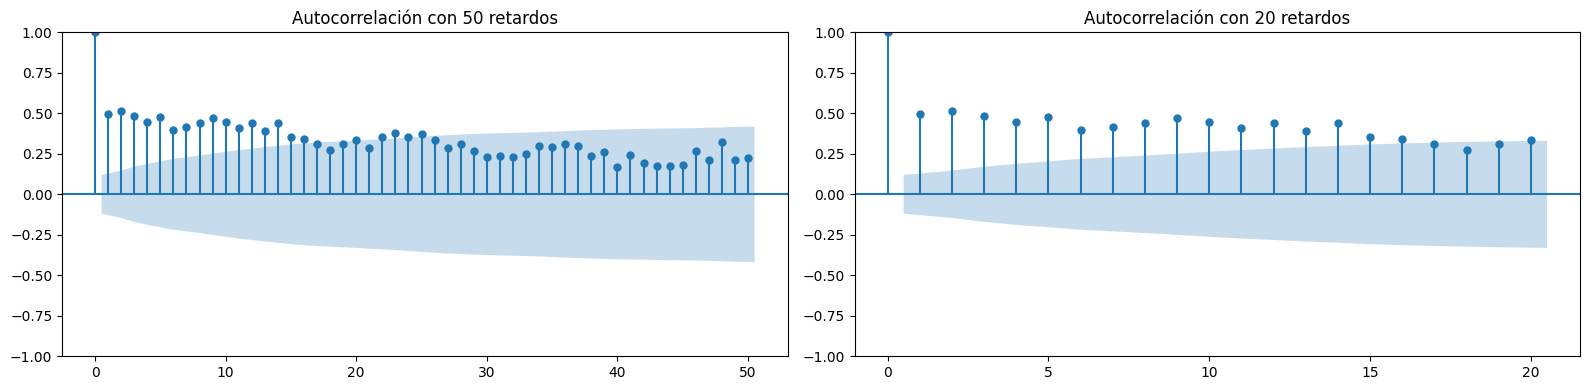

In [489]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(data_diesel['diesel_boxcox'], lags=50, ax=ax[0])
ax[0].set_title("Autocorrelación con 50 retardos")

plot_acf(data_diesel['diesel_boxcox'], lags=20, ax=ax[1])
ax[1].set_title("Autocorrelación con 20 retardos")

plt.tight_layout()
plt.show()

In [490]:
print('Resultados del Test de Dickey Fuller')
dfTest2 = adfuller(data_diesel['diesel_boxcox'], autolag='AIC')
salidaDf2 = pd.Series(dfTest2[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest2[4].items():
        salidaDf2['Critical Value (%s)'%key] = value
print(salidaDf2)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.373701
p-value                        0.594817
# de retardos usados          13.000000
# de observaciones usadas    255.000000
Critical Value (1%)           -3.456257
Critical Value (5%)           -2.872942
Critical Value (10%)          -2.572846
dtype: float64


En base al gráfico de autocorrelación y el test de Dickey Fuller se confirma que la serie no es estacionaria en media. Porque no se puede rechazar la hipótesis nula del test de Dickey Fuller ya que el valor de p (0.594817) es mayor a 0.05, lo cual también indica que puede haber más de una raíz unitaria. Por tanto, es necesario hacer una diferenciación.

In [491]:
data_diesel['diesel_boxcox_diff'] = data_diesel['diesel_boxcox'].diff()
data_diesel.dropna(subset=['diesel_boxcox_diff'], inplace=True)

dfTest2 = adfuller(data_diesel['diesel_boxcox_diff'], autolag='AIC')
salidaDf2 = pd.Series(dfTest2[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest2[4].items():
        salidaDf2['Critical Value (%s)'%key] = value
print(salidaDf2)

Estadístico de prueba       -8.315823e+00
p-value                      3.683336e-13
# de retardos usados         1.200000e+01
# de observaciones usadas    2.550000e+02
Critical Value (1%)         -3.456257e+00
Critical Value (5%)         -2.872942e+00
Critical Value (10%)        -2.572846e+00
dtype: float64


Despues de aplicar una diferenciación de orden 1, se obtiene una serie estacionaria en media con un valor de 3.742521e-13, por lo que se puuede rechazar la  hipótesis nula de Dickey-Fuller.

### Parámetros p, d y q - Serie: Diesel

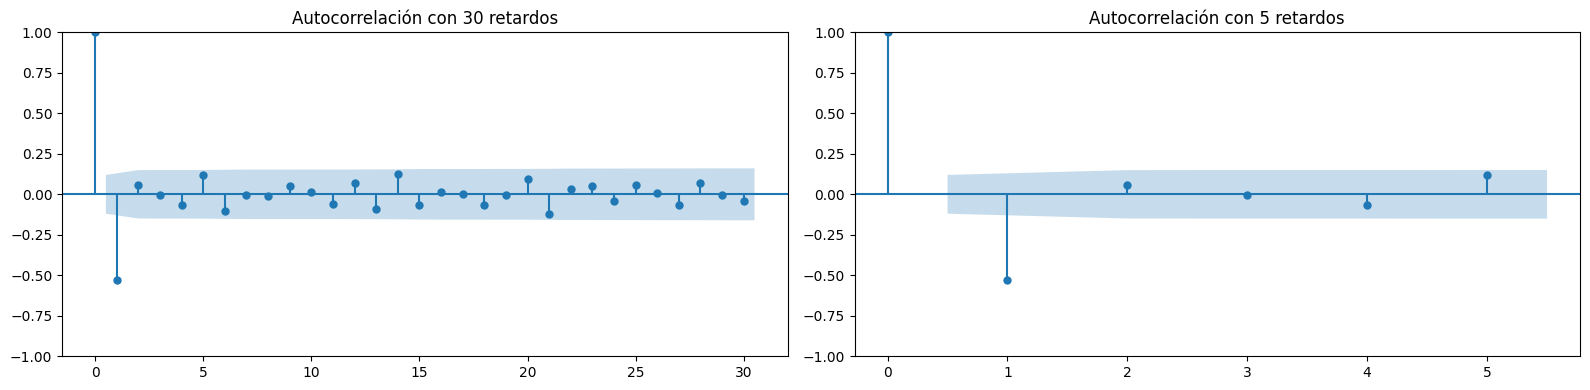

In [492]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

plot_acf(data_diesel['diesel_boxcox_diff'].dropna(), lags=30, title='Función de Autocorrelación con 30 retardos', ax=ax[0])
ax[0].set_title("Autocorrelación con 30 retardos")

plot_acf(data_diesel['diesel_boxcox_diff'].dropna(), lags=5, title='Función de Autocorrelación con 5 retardos', ax=ax[1])
ax[1].set_title("Autocorrelación con 5 retardos")

plt.tight_layout()
plt.show()


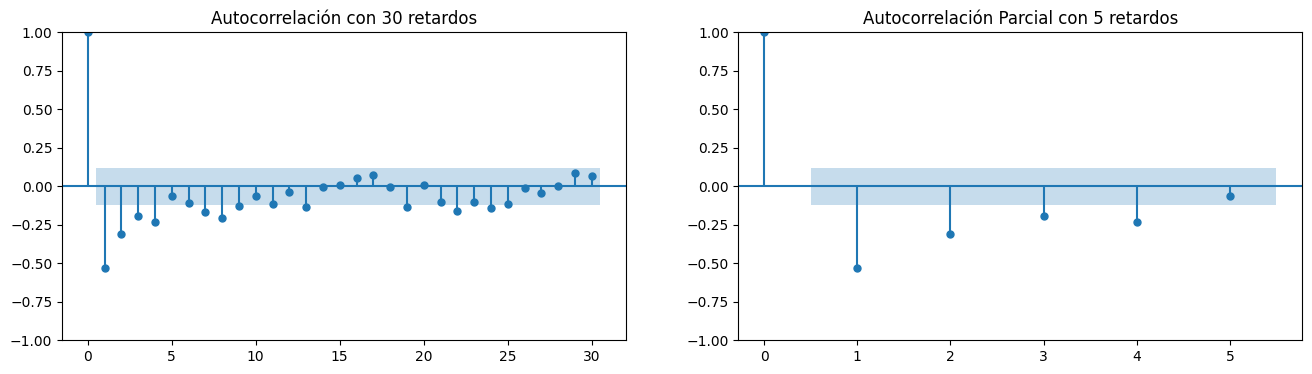

In [493]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_pacf(data_diesel['diesel_boxcox_diff'], lags=30, title='Función de Autocorrelación Parcial 30 retardos', alpha=0.05, ax=ax[0])
ax[0].set_title("Autocorrelación con 30 retardos")

plot_pacf(data_diesel['diesel_boxcox_diff'], lags=5, title='Función de Autocorrelación 30 retardos', alpha=0.05, ax=ax[1])
ax[1].set_title("Autocorrelación Parcial con 5 retardos")

plt.show()


p = 1, q = 1, d = 1

### Estacionalidad

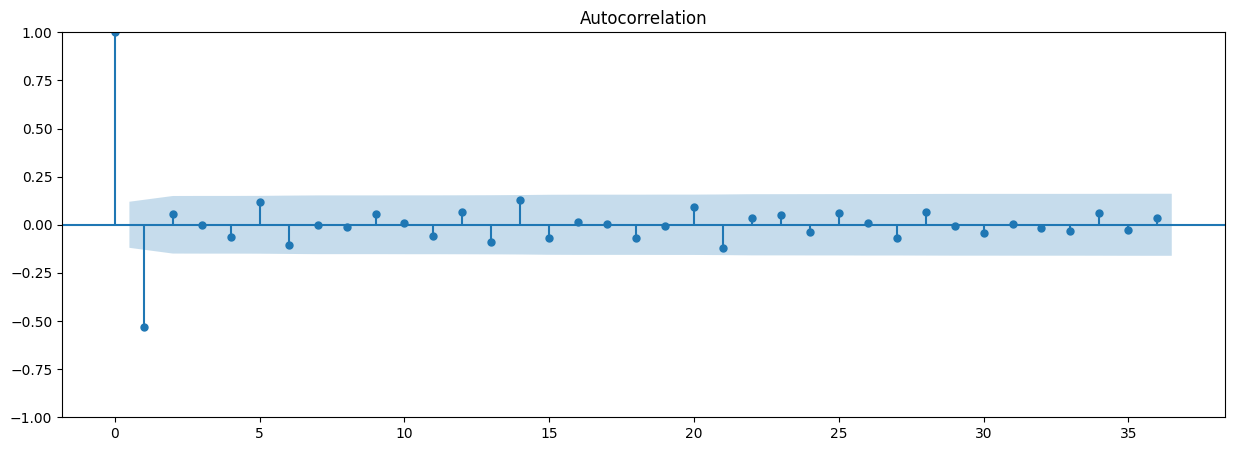

In [494]:
plot_acf(data_diesel['diesel_boxcox_diff'], lags=36)
plt.show()

Se observa que hay estacionalidad cada 5 meses, por tanto, se debe agregar el componente estacional. 

In [495]:
data_diesel['diesel_boxcox_diff_5'] = data_diesel['diesel_boxcox_diff'].diff(5)
data_diesel.dropna(subset=['diesel_boxcox_diff_5'], inplace=True)

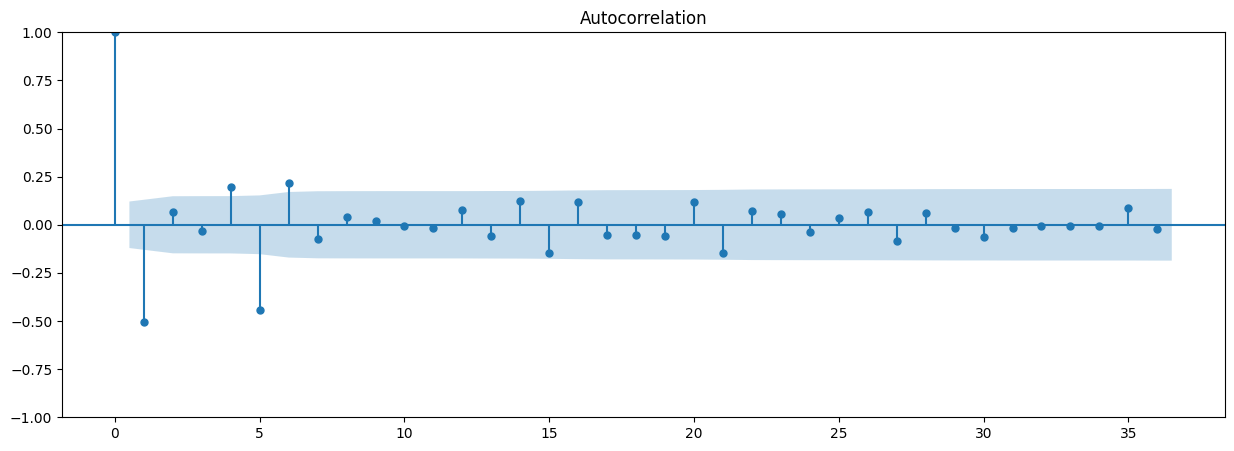

In [496]:
plot_acf(data_diesel['diesel_boxcox_diff_5'], lags=36)
plt.show()

Los componentes se anulan los coeficientes después de p=6. Por tanto, p=6, d=1, q=0.

In [497]:
data_diesel['fecha'] = pd.to_datetime(data_diesel['fecha'])
data_diesel.set_index('fecha', inplace=True)
data_diesel.index.freq = 'MS'


modelo_import_diesel = SARIMAX(data_diesel['diesel_boxcox'], order=(1,1,1), seasonal_order=(6,1,0,5), enforce_stationarity=False, enforce_invertibility=False)
res_mid = modelo_import_diesel.fit()
print(res_mid.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91930D+00    |proj g|=  1.11351D-01

At iterate    5    f=  5.87062D+00    |proj g|=  1.94863D-02


 This problem is unconstrained.



At iterate   10    f=  5.87001D+00    |proj g|=  1.56922D-03

At iterate   15    f=  5.86956D+00    |proj g|=  9.60886D-03

At iterate   20    f=  5.86484D+00    |proj g|=  2.94410D-02

At iterate   25    f=  5.78350D+00    |proj g|=  1.62484D-01

At iterate   30    f=  5.77106D+00    |proj g|=  2.24115D-02

At iterate   35    f=  5.77081D+00    |proj g|=  2.12886D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     45      1     0     0   3.428D-05   5.771D+00
  F =   5.7708061273195534     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>

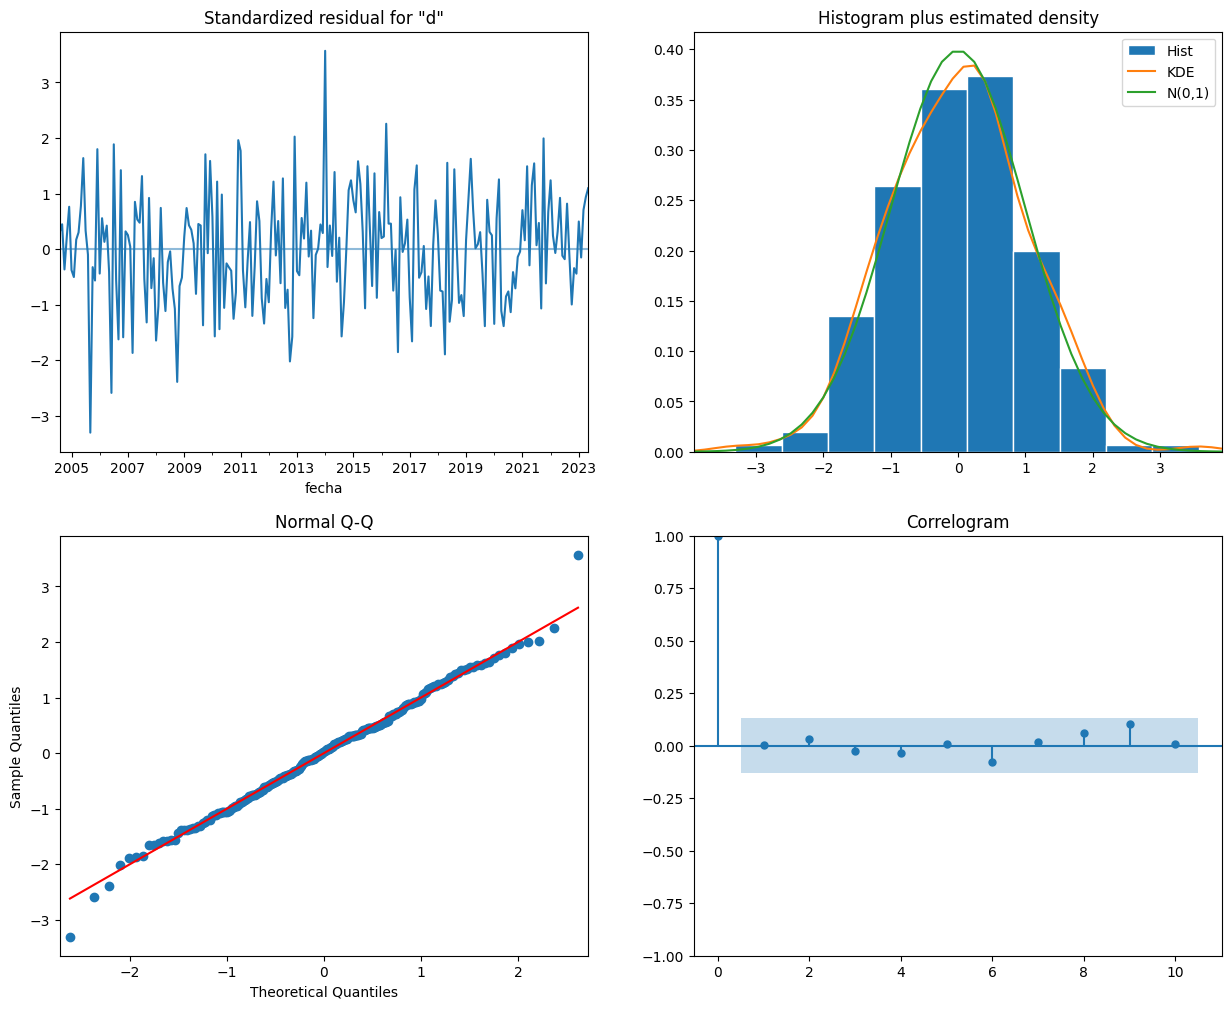

In [498]:
res_mid.plot_diagnostics(figsize=(15, 12))
plt.show()

Los residuos muestran una distribución normal, por lo que el modelo puede ser bueno generalizando información.

In [499]:
modelo_import_diesel2 = SARIMAX(data_diesel['diesel_boxcox'], order=(1,1,2), seasonal_order=(6,1,0,5), enforce_stationarity=False, enforce_invertibility=False)
res_mid2 = modelo_import_diesel2.fit()
print(res_mid2.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03134D+00    |proj g|=  5.36840D-01


 This problem is unconstrained.



At iterate    5    f=  5.93608D+00    |proj g|=  1.57048D-01

At iterate   10    f=  5.89541D+00    |proj g|=  1.79021D-01

At iterate   15    f=  5.87835D+00    |proj g|=  1.35478D-01

At iterate   20    f=  5.87542D+00    |proj g|=  2.73348D-03

At iterate   25    f=  5.87533D+00    |proj g|=  2.17330D-03

At iterate   30    f=  5.87505D+00    |proj g|=  4.07138D-03

At iterate   35    f=  5.87428D+00    |proj g|=  1.59124D-02

At iterate   40    f=  5.85625D+00    |proj g|=  3.35208D-02

At iterate   45    f=  5.80523D+00    |proj g|=  1.32734D-01

At iterate   50    f=  5.77107D+00    |proj g|=  5.33979D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/saramariapaguagagonzales/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9725      0.052    -18.774      0.000      -1.074      -0.871
ma.L1         -0.0525      0.086     -0.613      0.540      -0.220       0.115
ma.L2         -0.9600      0.089    -10.783      0.000      -1.134      -0.785
ar.S.L5       -0.7962      0.078    -10.246      0.000      -0.948      -0.644
ar.S.L10      -0.6081      0.095     -6.408      0.000      -0.794      -0.422
ar.S.L15      -0.5068      0.097     -5.230      0.000      -0.697      -0.317
ar.S.L20      -0.3433      0.095     -3.606      0.000      -0.530      -0.157
ar.S.L25      -0.0917      0.092     -0.994      0.320      -0.272       0.089
ar.S.L30      -0.1561      0.076     -2.048      0.041      -0.306      -0.007
sigma2      3.945e+04   4083.495      9.660      0.000    3.14e+04    4.74e+04


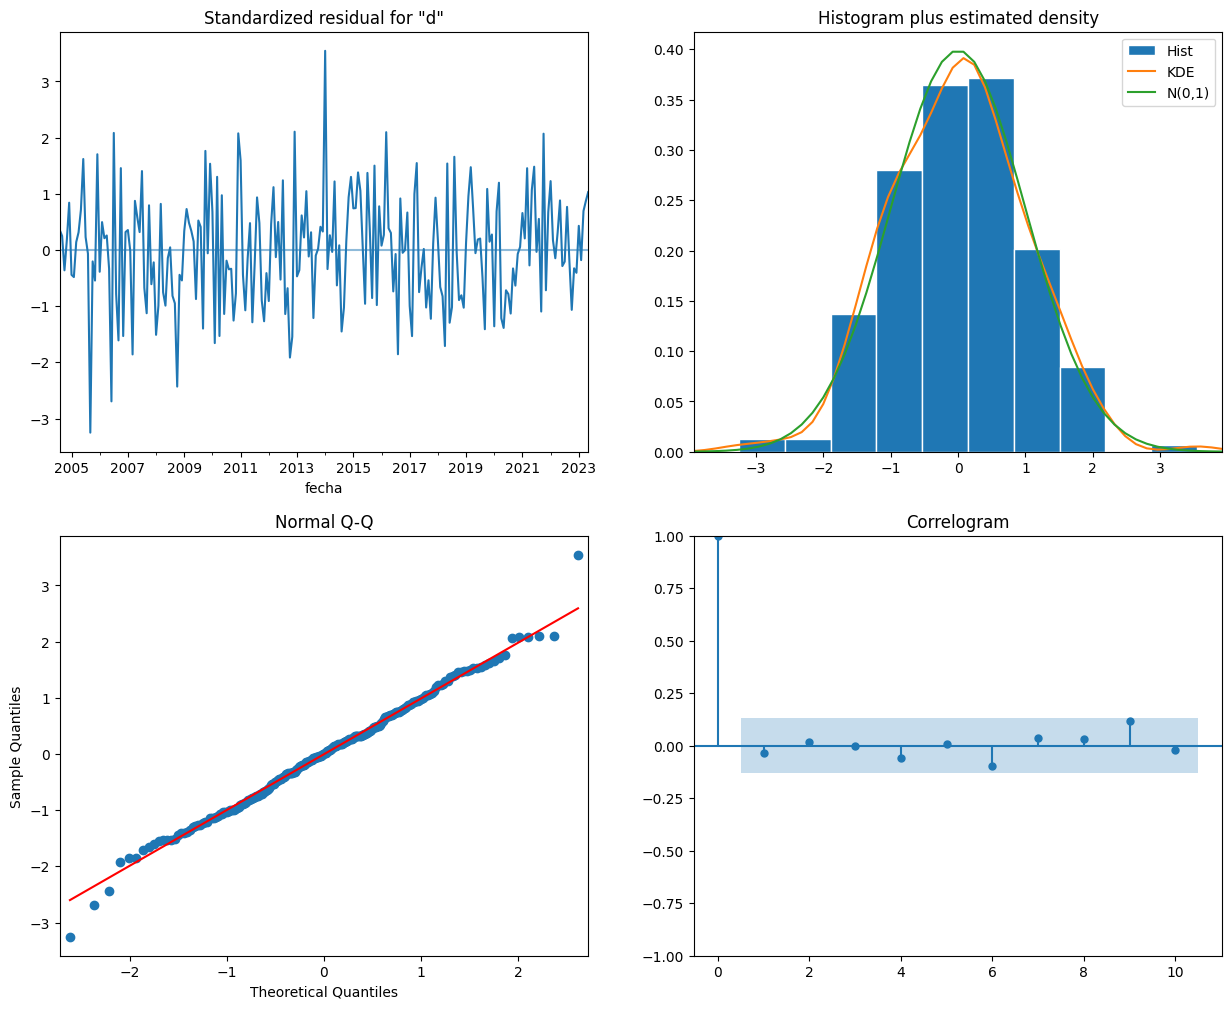

In [500]:
res_mid2.plot_diagnostics(figsize=(15, 12))
plt.show()

In [501]:
modelo_import_diesel3 = SARIMAX(data_diesel['diesel_boxcox'], order=(1,1,4), seasonal_order=(6,1,0,5), enforce_stationarity=False, enforce_invertibility=False)
res_mid3 = modelo_import_diesel3.fit()
print(res_mid3.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.88579D+00    |proj g|=  1.02132D-01

At iterate    5    f=  5.86455D+00    |proj g|=  3.22177D-02

At iterate   10    f=  5.86343D+00    |proj g|=  2.68902D-03

At iterate   15    f=  5.86334D+00    |proj g|=  2.58074D-03

At iterate   20    f=  5.86299D+00    |proj g|=  2.63032D-02

At iterate   25    f=  5.85746D+00    |proj g|=  3.03218D-02

At iterate   30    f=  5.85005D+00    |proj g|=  8.87401D-02

At iterate   35    f=  5.84561D+00    |proj g|=  3.08683D-02

At iterate   40    f=  5.83434D+00    |proj g|=  9.29849D-02

At iterate   45    f=  5.81163D+00    |proj g|=  6.68090D-02


/Users/saramariapaguagagonzales/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  5.78181D+00    |proj g|=  3.96719D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     72      1     0     0   3.967D-02   5.782D+00
  F =   5.7818070051847714     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8736      0.529     -1.652      0.099      -1.910       0.163
ma.L1         -0.0898      0.544     -0.165      0.869      -1.155       0.976
ma.L2         -0.8219      0.523     -1.571  

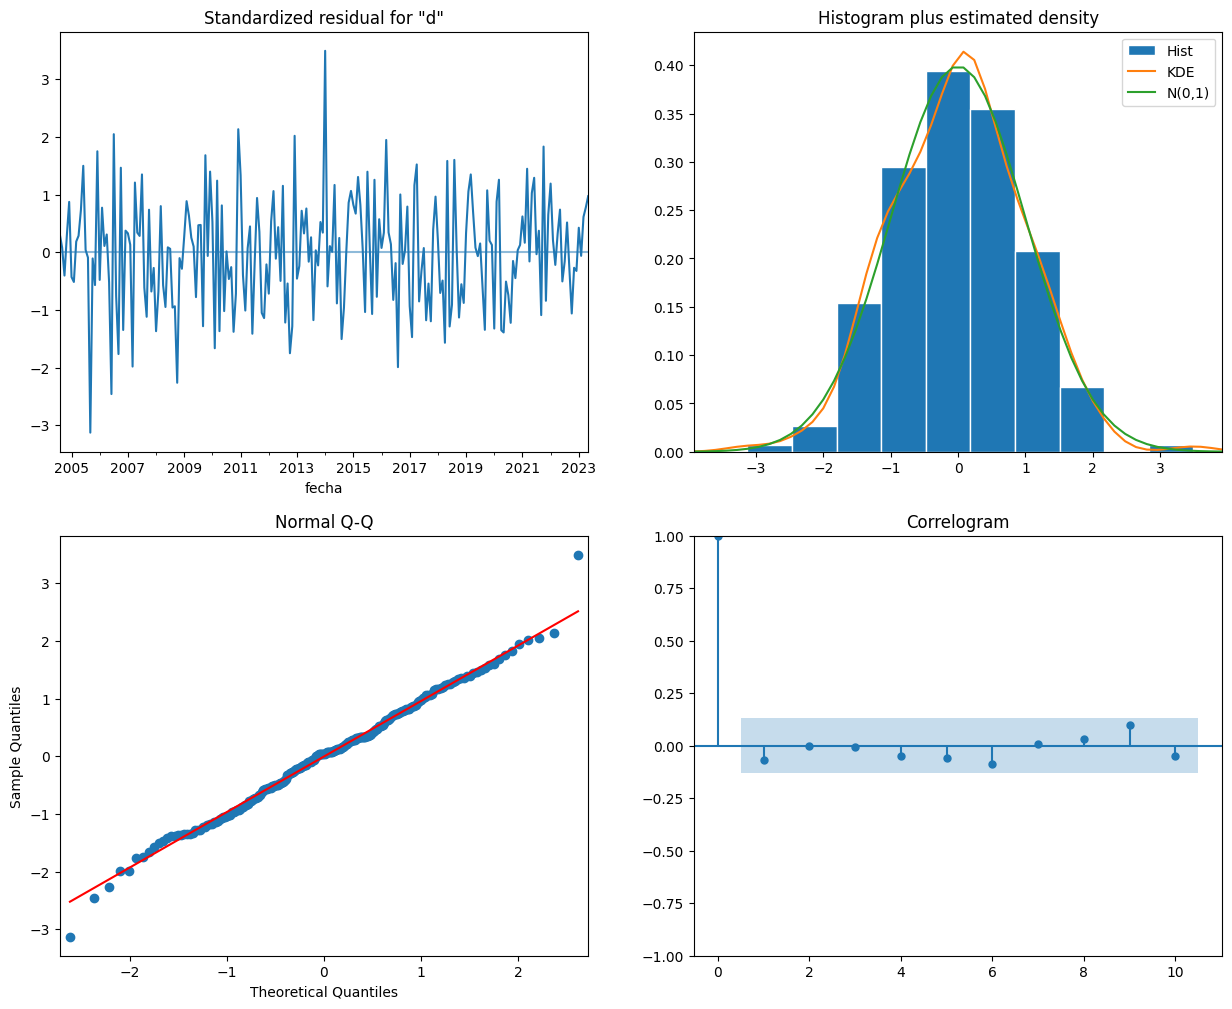

In [502]:
res_mid3.plot_diagnostics(figsize=(15, 12))
plt.show()

Los tres modelos parecen tener una distribución normal.

In [503]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 111=",res_mid.aic)
print("Modelo 112=",res_mid2.aic)
print("Modelo 114=",res_mid3.aic)

print()

print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 111=",res_mid.bic)
print("Modelo 112=",res_mid2.bic)
print("Modelo 114=",res_mid3.bic)

Resultados de AIC (Akaike information criterion)
Modelo 111= 3053.444022970085
Modelo 112= 3055.583086473409
Modelo 114= 3065.23048472719

Resultados de BIC (Bayesian information criterion)
Modelo 111= 3084.2288379635356
Modelo 112= 3089.7884364661318
Modelo 114= 3106.2769047184574


Según los criterios AIC y BIC, el modelo 114 podría ser el más adecuado. Aunque el modelo 111 tiene el valor más bajo en AIC, no hay una gran diferencia respecto al 114, que es quien tiene el valor más bajo. No obstante, cuando se observa el BIC, el modelo 114 muestra una ventaja significativa en comparación con los otros modelos.

## Serie - Importación mensual de gas licuado

In [509]:
data_gas_licuado = data.copy()
data_gas_licuado.rename(columns={'gas_licuado_petroleo': 'gas_licuado'}, inplace=True)

data_gas_licuado['media_movil_gas_licuado'] = data_gas_licuado['gas_licuado'].rolling(window=12).mean()

fig = px.line(data_gas_licuado, x='fecha', y='gas_licuado', 
              labels={'gas_licuado': 'Cantidad de gas licuado petróleo'}, 
              title='Gas licuado por mes cada año', markers=True)

fig.add_scatter(x=data_gas_licuado['fecha'], y=data_gas_licuado['media_movil_gas_licuado'], 
                mode='lines', name='Media móvil - 12 meses')

fig.update_xaxes(tickformat="%Y", title_text='Año')
fig.update_traces(line=dict(width=2.5))
fig.show()


A primera vista no se observa estacionaridad en media ni en varianza. Sin embargo, si se puede observar una tendencia en la serie de tiempo.

In [506]:
d_serie_gl = seasonal_decompose(data_gas_licuado.set_index('fecha')['gas_licuado'].astype(float))
fig_gl = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Tendencia', 'Estacionalidad', 'Aleatoriedad'))

fig_gl.add_trace(go.Scatter(x=d_serie_gl.trend.index, y=d_serie_gl.trend, mode='lines', name='Tendencia'), row=1, col=1)
fig_gl.add_trace(go.Scatter(x=d_serie_gl.seasonal.index, y=d_serie_gl.seasonal, mode='lines', name='Estacionalidad'), row=2, col=1)
fig_gl.add_trace(go.Scatter(x=d_serie_gl.resid.index, y=d_serie_gl.resid, mode='lines', name='Aleatoriedad'), row=3, col=1)

fig_gl.update_layout(title='Descomposición de la serie de tiempo - Gas licuado petróleo')
fig_gl.show()

Hay una tendencia evidente y una estacionalidad notable. En cuanto al componente de aleatoriedad, no se identifica ningún patrón.

### Transformación de la serie
La serie requiere una transformación de tipo box-cox dado que no es estacionaria en varianza.

In [514]:
data_gas_licuado['gas_licuado_boxcox'] = boxcox(data_gas_licuado['gas_licuado'])[0]
fig = px.line(data_gas_licuado, x='fecha', y='gas_licuado_boxcox', title='Gas licuado petróleo - Transformación box cox', markers=True)

fig.show()


In [516]:
data_gas_licuado['gas_licuado_log'] = np.log(data_gas_licuado['gas_licuado'])
fig = px.line(data_gas_licuado, x='fecha', y='gas_licuado_log', title='Gas licuado petróleo - Transformación logarítmica', markers=True)

fig.show()


En este caso, la transformación logarítmica muestra una mayor estacionaridad en la varianza en comparación con la transformación de Box-Cox.

### Estacionaridad en media

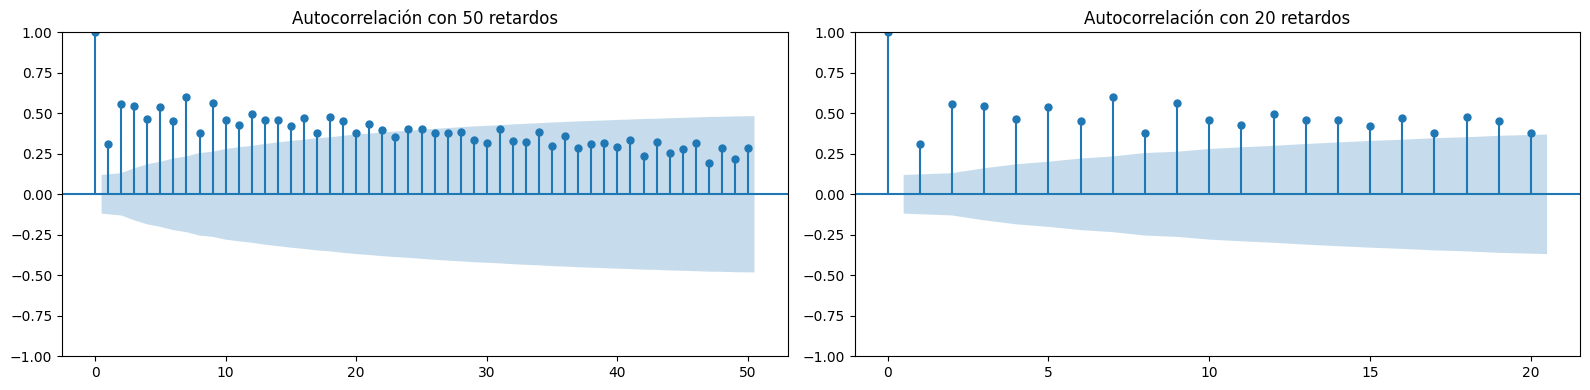

In [518]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(data_gas_licuado['gas_licuado_log'], lags=50, ax=ax[0])
ax[0].set_title("Autocorrelación con 50 retardos")

plot_acf(data_gas_licuado['gas_licuado_log'], lags=20, ax=ax[1])
ax[1].set_title("Autocorrelación con 20 retardos")

plt.tight_layout()
plt.show()

In [519]:
print('Resultados del Test de Dickey Fuller')
dfTest2 = adfuller(data_gas_licuado['gas_licuado_log'], autolag='AIC')
salidaDf2 = pd.Series(dfTest2[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest2[4].items():
        salidaDf2['Critical Value (%s)'%key] = value
print(salidaDf2)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.214101
p-value                        0.667501
# de retardos usados           9.000000
# de observaciones usadas    259.000000
Critical Value (1%)           -3.455853
Critical Value (5%)           -2.872765
Critical Value (10%)          -2.572752
dtype: float64


En base al gráfico de autocorrelación y el test de Dickey Fuller se confirma que la serie no es estacionaria en media. Porque no se puede rechazar la hipótesis nula del test de Dickey Fuller ya que el valor de p (0.667501) es mayor a 0.05, lo cual también indica que puede haber al menos una raíz unitaria. Por tanto, es necesario hacer una diferenciación.

In [520]:
data_gas_licuado['gas_licuado_log_diff'] = data_gas_licuado['gas_licuado_log'].diff()
data_gas_licuado.dropna(subset=['gas_licuado_log_diff'], inplace=True)

dfTest2 = adfuller(data_gas_licuado['gas_licuado_log_diff'], autolag='AIC')
salidaDf2 = pd.Series(dfTest2[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest2[4].items():
        salidaDf2['Critical Value (%s)'%key] = value
print(salidaDf2)

Estadístico de prueba       -1.116152e+01
p-value                      2.780315e-20
# de retardos usados         8.000000e+00
# de observaciones usadas    2.590000e+02
Critical Value (1%)         -3.455853e+00
Critical Value (5%)         -2.872765e+00
Critical Value (10%)        -2.572752e+00
dtype: float64


Despues de aplicar una diferenciación de orden 1, se obtiene una serie estacionaria en media con un valor de 3.742521e-13, por lo que se puuede rechazar la  hipótesis nula de Dickey-Fuller.

### Parámetros p, d y q - Serie: Gas licuado petróleo

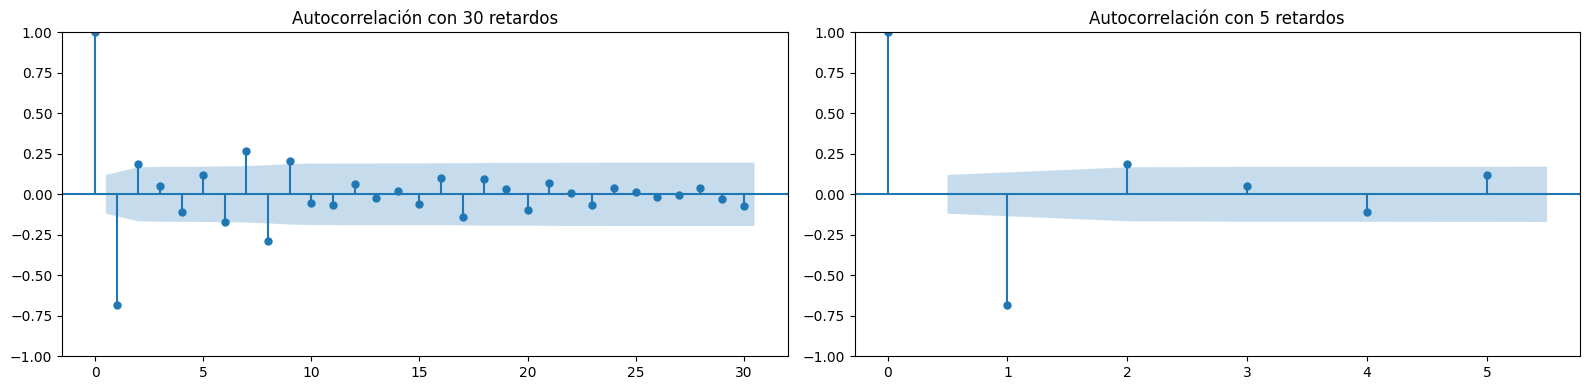

In [522]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

plot_acf(data_gas_licuado['gas_licuado_log_diff'].dropna(), lags=30, title='Función de Autocorrelación con 30 retardos', ax=ax[0])
ax[0].set_title("Autocorrelación con 30 retardos")

plot_acf(data_gas_licuado['gas_licuado_log_diff'].dropna(), lags=5, title='Función de Autocorrelación con 5 retardos', ax=ax[1])
ax[1].set_title("Autocorrelación con 5 retardos")

plt.tight_layout()
plt.show()


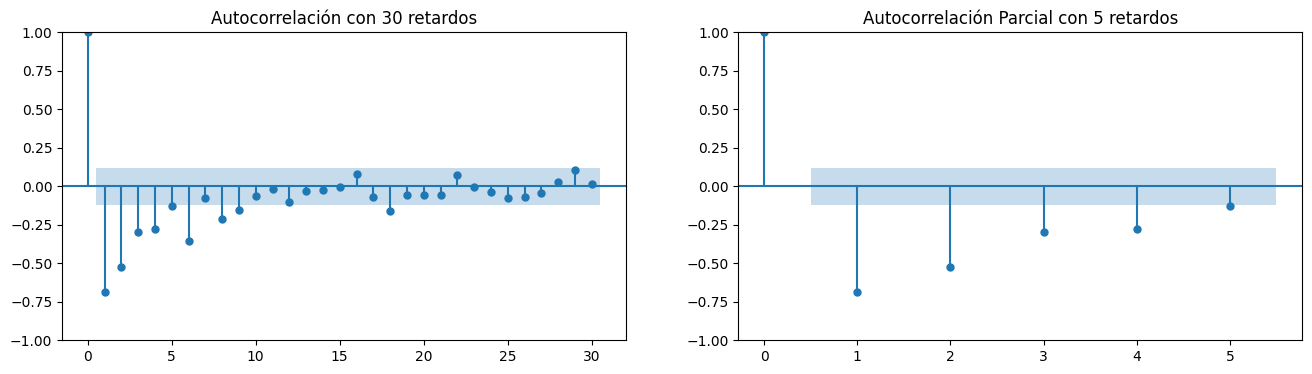

In [523]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_pacf(data_gas_licuado['gas_licuado_log_diff'], lags=30, title='Función de Autocorrelación Parcial 30 retardos', alpha=0.05, ax=ax[0])
ax[0].set_title("Autocorrelación con 30 retardos")

plot_pacf(data_gas_licuado['gas_licuado_log_diff'], lags=5, title='Función de Autocorrelación 30 retardos', alpha=0.05, ax=ax[1])
ax[1].set_title("Autocorrelación Parcial con 5 retardos")

plt.show()


p = 1, q = 1, d = 1

### Estacionalidad

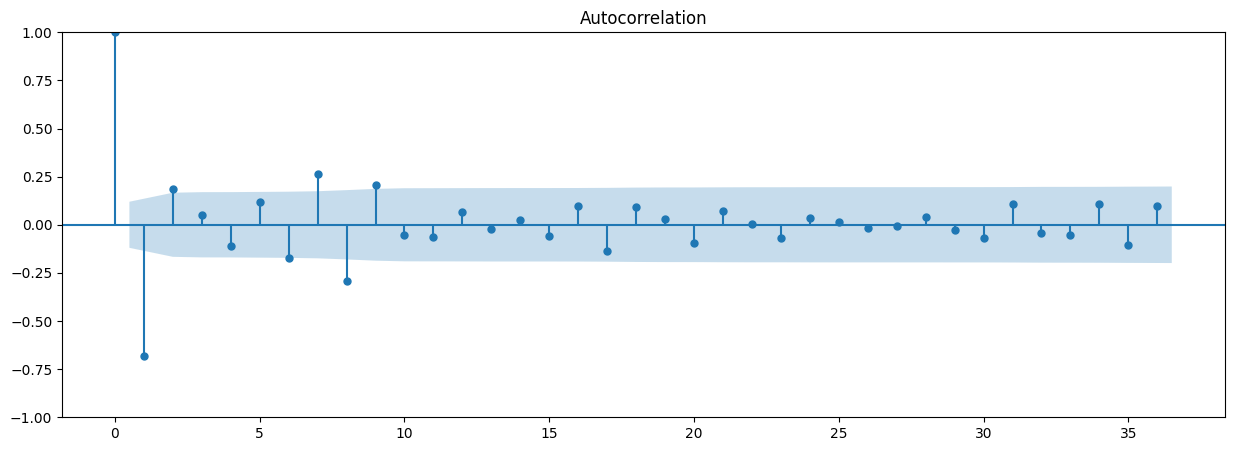

In [524]:
plot_acf(data_gas_licuado['gas_licuado_log_diff'], lags=36)
plt.show()

No se ve alguna estacionalidad.

In [525]:
data_gas_licuado['fecha'] = pd.to_datetime(data_gas_licuado['fecha'])
data_gas_licuado.set_index('fecha', inplace=True)
data_gas_licuado.index.freq = 'MS'


modelo_import_gas_licuado = SARIMAX(data_gas_licuado['gas_licuado_log'], order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
res_migl = modelo_import_gas_licuado.fit()
print(res_migl.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70884D-01    |proj g|=  4.34375D-01

At iterate    5    f=  3.46154D-01    |proj g|=  2.65181D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   1.092D-06   3.461D-01
  F =  0.34611452808960347     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

 This problem is unconstrained.


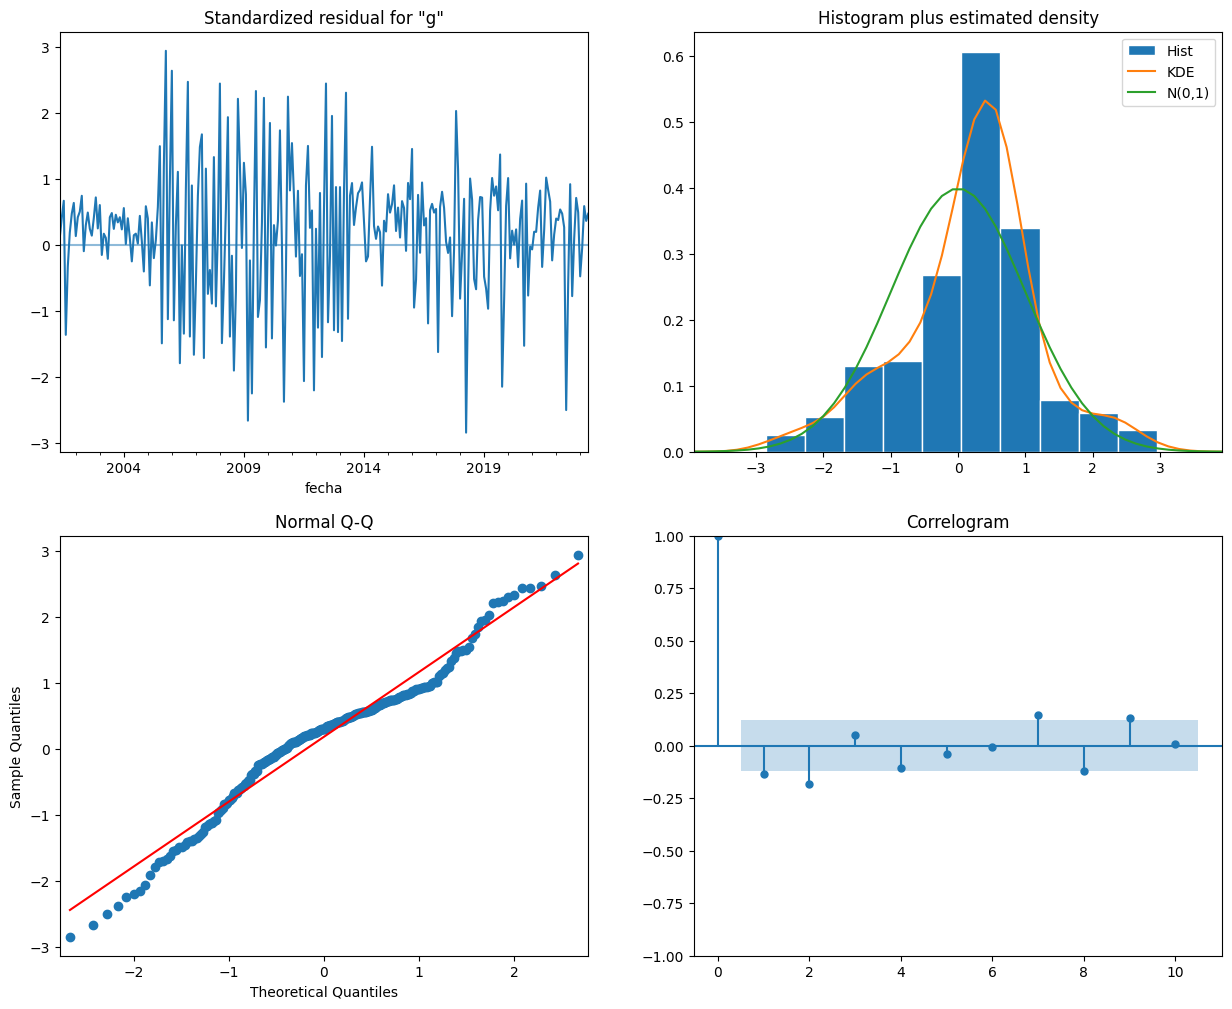

In [526]:
res_migl.plot_diagnostics(figsize=(15, 12))
plt.show()

In [527]:
modelo_import_gas_licuado2 = SARIMAX(data_gas_licuado['gas_licuado_log'], order=(1,1,5), enforce_stationarity=False, enforce_invertibility=False)
res_migl2 = modelo_import_gas_licuado2.fit()
print(res_migl2.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01159D-01    |proj g|=  4.02031D+00

At iterate    5    f=  3.00422D-01    |proj g|=  6.80131D-02

At iterate   10    f=  2.98770D-01    |proj g|=  3.68415D-02

At iterate   15    f=  2.97880D-01    |proj g|=  1.05502D-03

At iterate   20    f=  2.97879D-01    |proj g|=  2.75283D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     28      1     0     0   3.576D-06   2.979D-01
  F =  0.29787915714533419     

CONVERG

 This problem is unconstrained.


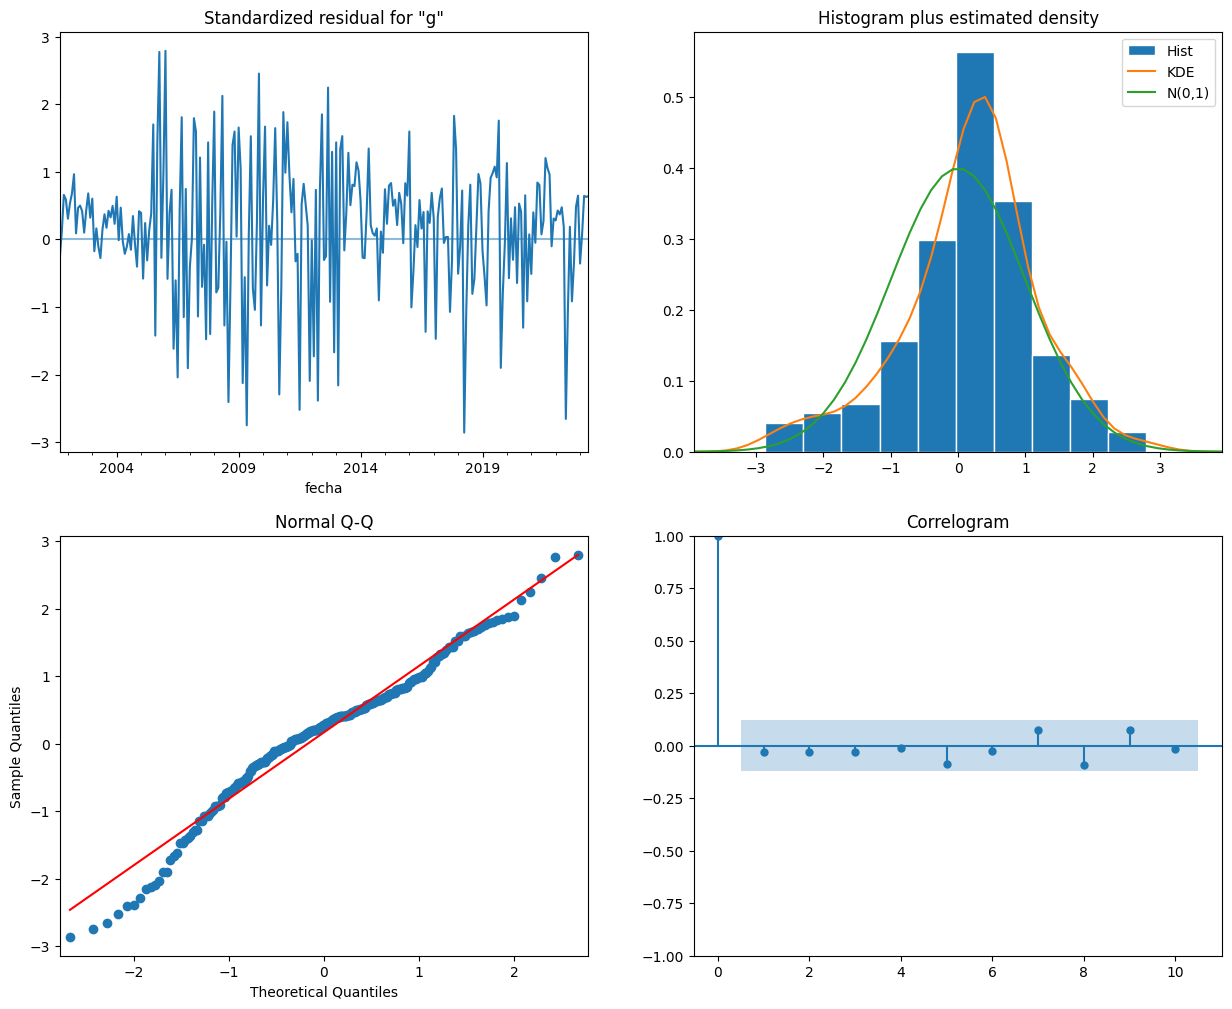

In [528]:
res_migl2.plot_diagnostics(figsize=(15, 12))
plt.show()

In [534]:
modelo_import_gas_licuado3 = SARIMAX(data_gas_licuado['gas_licuado_log'], order=(2,1,5), enforce_stationarity=False, enforce_invertibility=False)
res_migl3 = modelo_import_gas_licuado3.fit()
print(res_migl3.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72939D-01    |proj g|=  1.61622D+00

At iterate    5    f=  3.05533D-01    |proj g|=  7.61728D-02

At iterate   10    f=  3.00786D-01    |proj g|=  3.85974D-02

At iterate   15    f=  2.99710D-01    |proj g|=  9.81151D-03

At iterate   20    f=  2.99686D-01    |proj g|=  8.82659D-03

At iterate   25    f=  2.99066D-01    |proj g|=  5.33667D-02

At iterate   30    f=  2.98167D-01    |proj g|=  1.00451D-02

At iterate   35    f=  2.98035D-01    |proj g|=  6.47752D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


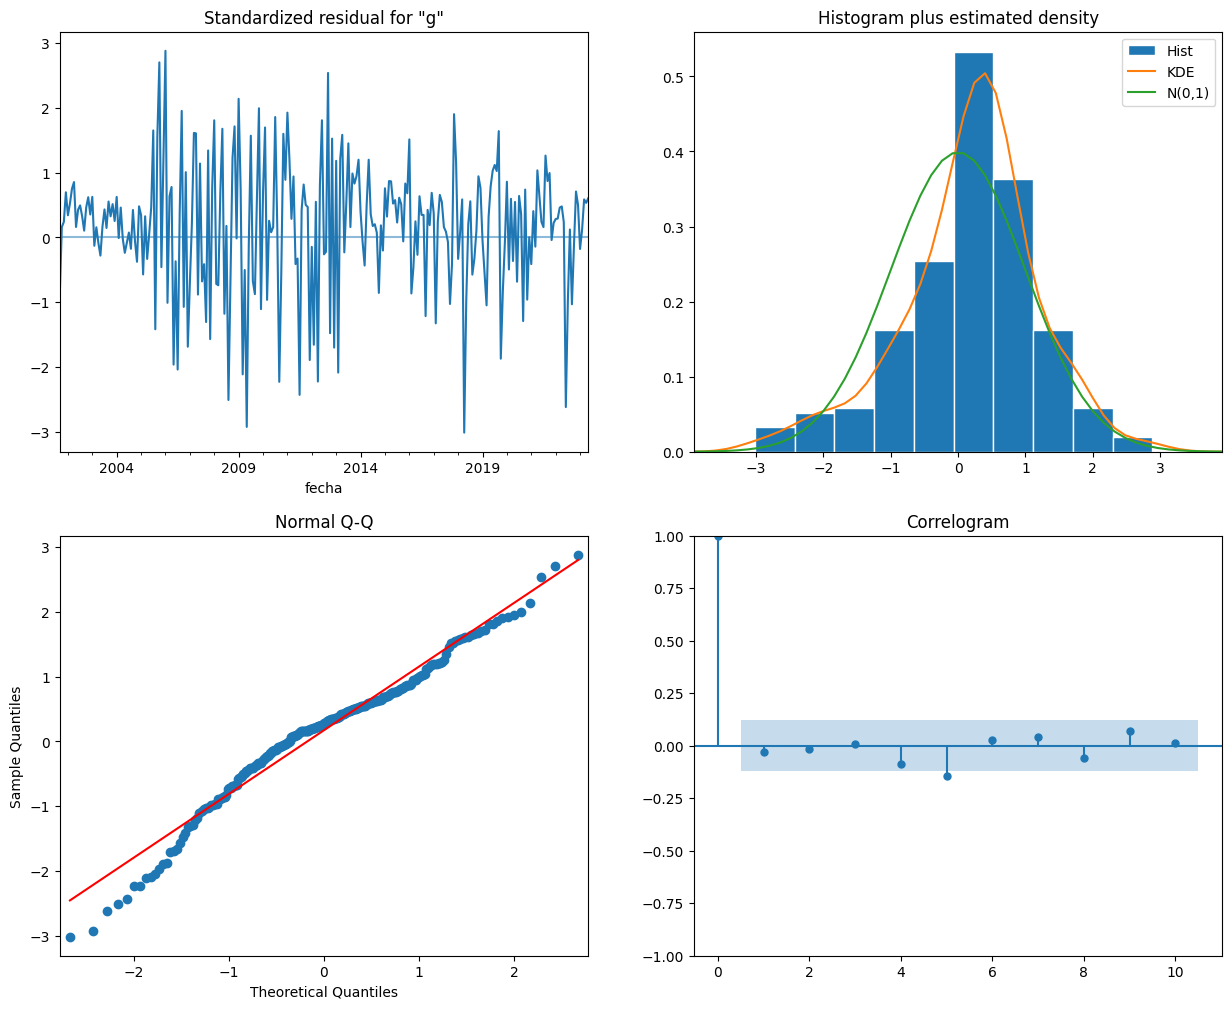

In [535]:
res_migl3.plot_diagnostics(figsize=(15, 12))
plt.show()

In [536]:
modelo_import_gas_licuado4 = SARIMAX(data_gas_licuado['gas_licuado_log'], order=(6,1,5), enforce_stationarity=False, enforce_invertibility=False)
res_migl4 = modelo_import_gas_licuado4.fit()
print(res_migl3.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83092D-01    |proj g|=  1.22604D-01

At iterate    5    f=  2.80561D-01    |proj g|=  2.01461D-02

At iterate   10    f=  2.79805D-01    |proj g|=  1.02723D-02

At iterate   15    f=  2.79517D-01    |proj g|=  1.57731D-02

At iterate   20    f=  2.79233D-01    |proj g|=  2.50402D-02

At iterate   25    f=  2.78766D-01    |proj g|=  9.86304D-03

At iterate   30    f=  2.78295D-01    |proj g|=  1.00208D-02

At iterate   35    f=  2.78201D-01    |proj g|=  1.60015D-03

At iterate   40    f=  2.78200D-01    |proj g|=  4.77090D-04

At iterate   45    f=  2.78199D-01    |proj g|=  5.05001D-04

At iterate   50    f=  2.78198D-01    |proj g|=  5.43331D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
/Users/saramariapaguagagonzales/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



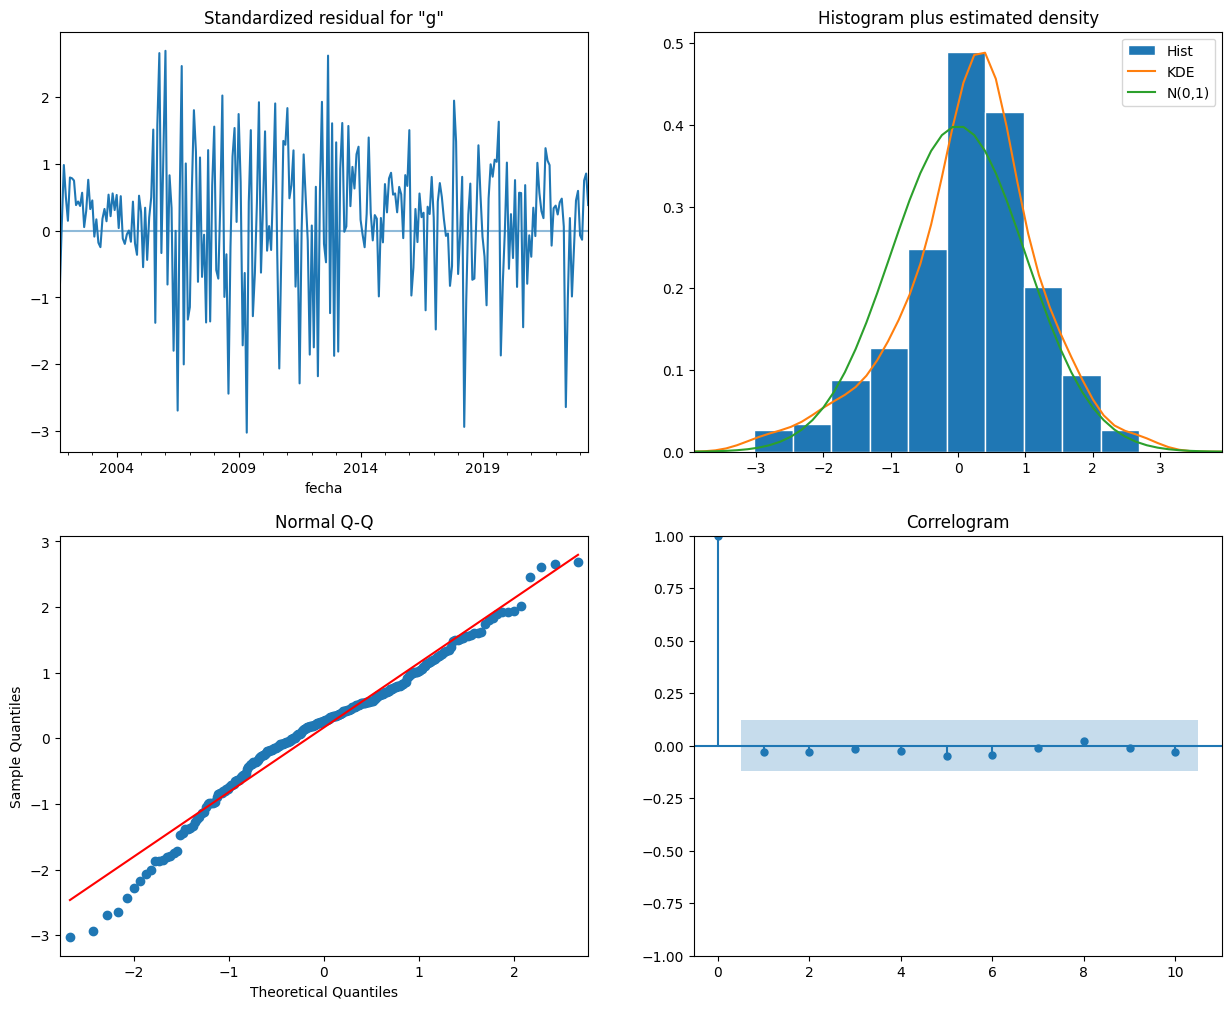

In [537]:
res_migl4.plot_diagnostics(figsize=(15, 12))
plt.show()

Se observa que los modelos que tienen una mayor disytribución normal aquellos con valores p=2, d=1 y q=5 y p=6, d=1, q=5. Además, en el modelo con valores p=6, d=1, q=5 se nota en el correlograma que ya no hay valores significativos.

In [538]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 111=",res_migl.aic)
print("Modelo 115=",res_migl2.aic)
print("Modelo 215=",res_migl3.aic)
print("Modelo 615=",res_migl4.aic)

print()

print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 111=",res_migl.bic)
print("Modelo 115=",res_migl2.bic)
print("Modelo 215=",res_migl3.bic)
print("Modelo 615=",res_migl4.bic)

Resultados de AIC (Akaike information criterion)
Modelo 111= 191.51738705602747
Modelo 115= 173.66322822989912
Modelo 215= 175.74691015235123
Modelo 615= 173.11429698688943

Resultados de BIC (Bayesian information criterion)
Modelo 111= 202.25657653398613
Modelo 115= 198.61487108115796
Modelo 215= 204.26307341093278
Modelo 615= 215.88854187476176


Según los criterios AIC y BIC el modelo que mejor se ajusta es el modelo ARIMA(1,1,5).